In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
import os 

In [2]:
from sklearn.preprocessing import MinMaxScaler

### Define functions

In [3]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[2]-step,step):
        d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
        count +=1
    return d_avg

In [28]:
def get_task_variables(data:SpikeData,bhv:BhvData):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    cgroup = "all"
    in_out='in'
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]
    # print("Number of clusters: %d" % len(data.clustersgroup))
    #print("Number of %s units: %d" % (cgroup, len(neurons)))
    task = task[task['in_out']==in_out]


    return task, trial_idx

In [5]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples

In [6]:
def delete_match(test_stimuli):
    bool_m = np.where(np.isnan(test_stimuli),0,1)
    bool_m = np.concatenate([bool_m,np.ones((bool_m.shape[0],1))],axis=1)
    bool_diff = bool_m[:,:-1] - bool_m[:,1:] 
    good_tr = np.where(bool_diff == 1, False,bool_m[:,:-1]).astype(bool)
    test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)
    return test_stimuli

### Compute tuning

In [7]:
# filepath = "/home/INT/losada.c/Documents/data/Riesling/session_struct/lip/spikes/2023-01-18_10-22-38_Riesling_lip_e1_r1_sp.h5" 
# bhvpath = '/home/INT/losada.c/Documents/data/Riesling//session_struct/bhv/2023-01-18_10-22-38_Riesling_e1_r1_bhv.h5'
# s_path = os.path.normpath(filepath).split(os.sep)

In [8]:
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### Color and direction selectivity

In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
df 

In [ ]:
# 3-way ANOVA
# with sample identity (A, B, C or D), test color, and test direction as factors
# Only included non-matching test stimuli
# Period selectivity for each neuron: fixed time window between 100 and 400 ms following test onset



#perform three-way ANOVA
model = ols("""height ~ C(sample) + C(test_color) + C(test_orient) +
               C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient) +
               C(sample):C(test_color):C(test_orient)""", data=df).fit()


In [49]:
feature = 'o1'
op_feature = 'o5'
orientation = 0
color = 1
color_orient = orientation
stim_num=['1','2','3','4','5','6','7','8']

# Read data
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)
task, trial_idx = get_task_variables(data,bhv)
# 
for feat in [feature,op_feature]:
    test_stimuli,code_numbers,code_samples,sp_samples = get_trials_by_sample(task,feature,trial_idx,bhv,data)
    sample_on = code_samples[:,4].astype(int)

    shifts = sample_on[:,np.newaxis]
    shift_sp = SpikeData.indep_roll(sp_samples, -shifts, axis=2)[:,:, :450].mean(axis=0)

In [ ]:
# 1 aligne sample presentation
# 2 split by sample 
# 3 compute avg (throw time) for each sample
# 4 compute t-test 

In [50]:
sp_avg_all = []

for n_bhv,n_sp in zip(paths_bhv[:2],paths_sp[:2]):
    
    feature = 'o1'
    op_feature = 'o5'
    orientation = 0
    color = 1
    color_orient = orientation
    stim_num=['1','2','3','4','5','6','7','8']

    # Read data
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    
    # Select trials with more than one trial
    task = task[task['n_test_stimuli'] > 1]
    test_stimuli,code_numbers,code_samples,sp_samples = get_trials_by_sample(task,feature,trial_idx,bhv,data)
    test_stimuli = delete_match(test_stimuli)

    shift_sp = []
    for i in stim_num:
        i_trial, i_test = np.where(np.char.find(test_stimuli,i)==color_orient)
        tests_on = code_samples[i_trial,i_test+6].astype(int)
        sp_stim = sp_samples[i_trial]
        shifts = tests_on[:,np.newaxis]
        shift_sp.append(SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, :450].mean(axis=0))
    shift_sp=np.array(shift_sp)

    sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
    neurons_max = np.max(sp_avg,axis=0)
    neurons_max = np.where(neurons_max==0,1,neurons_max)
    neurons_max = neurons_max[np.newaxis,:]
    sp_avg = sp_avg/(neurons_max)
    sp_avg_all.append(sp_avg)
sp_avg_all = np.concatenate(sp_avg_all,axis=1)

/tmp/ipykernel_35302/4054691977.py:6: RuntimeWarning: invalid value encountered in cast
  test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)


In [41]:
stim_num

['1', '2', '3', '4', '5', '6', '7', '8']

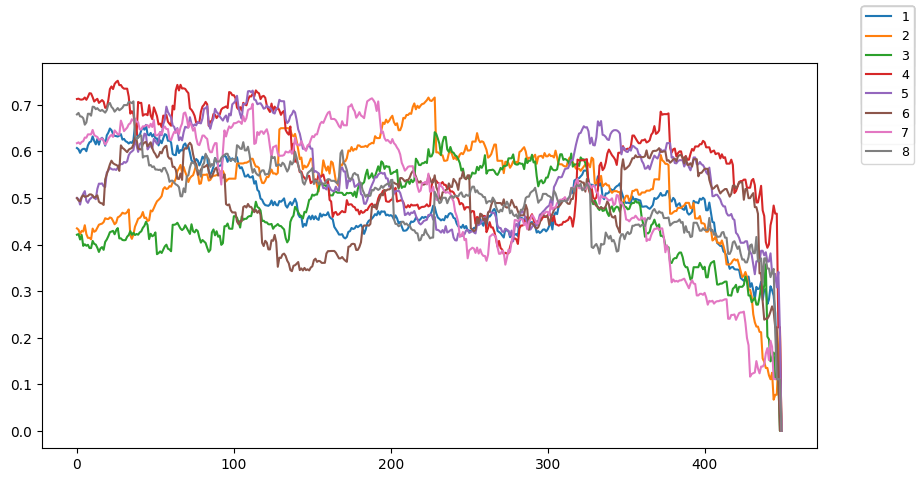

In [51]:
fig, ax = plt.subplots(figsize = (10,5))
y_avg = np.mean(sp_avg_all,axis=1)
for i,orient in enumerate(stim_num):
    y = y_avg[i] #[i_neuron]
    ax.plot(y,label=orient)
    fig.legend(fontsize=9)

In [27]:
sp_avg_all.shape

(8, 159, 450)